In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import json
import os
import sys
from pathlib import Path

# Add repo to path
repo_root = Path.cwd().parents[1]
sys.path.append(str(repo_root))

from modules.feature_engineering.feature_utils import make_features

# Create artifacts directory
os.makedirs("../../artifacts", exist_ok=True)
os.makedirs("images", exist_ok=True)

print("✓ Imports complete")

✓ Imports complete


In [ ]:
# Load data
data_path = Path("../../data")

train = pd.read_csv(data_path / "train.csv", parse_dates=["Date"])
features = pd.read_csv(data_path / "features.csv", parse_dates=["Date"])
stores = pd.read_csv(data_path / "stores.csv")

# Drop IsHoliday from train since it's also in features (avoid duplicate columns)
train = train.drop(columns=['IsHoliday'])

df_original = (
    train
    .merge(features, on=["Store", "Date"], how="left")
    .merge(stores, on="Store")
)

df_original = df_original.sort_values(["Store", "Dept", "Date"])

print(f"✓ Loaded {len(df_original):,} records")
print(f"✓ IsHoliday column present: {'IsHoliday' in df_original.columns}")

In [6]:
# Load trained models
import lightgbm as lgb

# Global LightGBM model
global_lgbm_path = "../../artifacts/global_lgbm_model.pkl"
if not os.path.exists(global_lgbm_path):
    raise FileNotFoundError("⚠️ Global LightGBM model not found. Run 3_lgbm_forecast.ipynb first.")

global_lgbm = joblib.load(global_lgbm_path)
print("✓ Loaded global LightGBM model")

# Define entity combinations
selected_combos = [
    (1, 1), (1, 2), (1, 3), (1, 4), (1, 5),
    (2, 1), (2, 2), (2, 3),
    (3, 1), (3, 2),
]

# Load global Ridge model and scaler
ridge_global_path = "../../artifacts/ridge_global.pkl"
ridge_scaler_path = "../../artifacts/ridge_global_scaler.pkl"
ridge_features_path = "../../artifacts/ridge_global_features.txt"

if os.path.exists(ridge_global_path) and os.path.exists(ridge_scaler_path):
    ridge_global = joblib.load(ridge_global_path)
    ridge_scaler = joblib.load(ridge_scaler_path)
    with open(ridge_features_path, 'r') as f:
        ridge_feature_cols = [line.strip() for line in f.readlines()]
    print("✓ Loaded global Ridge model")
else:
    ridge_global = None
    print("⚠️ Ridge model not found")

# Load Prophet models (optional, for comparison)
prophet_models = {}
for store, dept in selected_combos:
    model_path = f"../../artifacts/prophet_store{store}_dept{dept}.pkl"
    if os.path.exists(model_path):
        prophet_models[(store, dept)] = joblib.load(model_path)

print(f"✓ Loaded {len(prophet_models)} Prophet models (baseline)")

✓ Loaded global LightGBM model
✓ Loaded global Ridge model
✓ Loaded 10 Prophet models (baseline)


In [7]:
# Production-Ready Ensemble: Ridge + LightGBM (NO DATA LEAKAGE)
# Using ORIGINAL data (no spike injection)
# Split: Train (weeks 1 to N-24) → Validation (weeks N-23 to N-12) → Test (weeks N-11 to N)

ensemble_results = []
adaptive_weights = {}
VAL_SIZE = 12  # Weeks for weight calculation
TEST_SIZE = 12  # Weeks for final evaluation

print("Creating Adaptive Ensemble: Ridge + LightGBM (Production-Ready)")
print("Split: Validation (weeks -24 to -13) for weights → Test (last 12 weeks)")
print("="*70)

for store, dept in selected_combos:
    print(f"\nStore {store}, Dept {dept}")
    
    # Prepare data
    ts = (
        df_original[(df_original["Store"] == store) & (df_original["Dept"] == dept)]
        [["Date", "Weekly_Sales", "IsHoliday"]]
        .set_index("Date")
        .rename(columns={"Weekly_Sales": "Weekly_Sales"})
        .sort_index()
    )
    
    feat_df = make_features(ts, target="Weekly_Sales").dropna()
    
    # STEP 1: Split data properly (no leakage)
    # Validation: weeks -24 to -13 (for calculating ensemble weights)
    # Test: weeks -12 to -1 (for final evaluation)
    X_val_base = feat_df.drop(columns=["Weekly_Sales", "IsHoliday"]).iloc[-(VAL_SIZE+TEST_SIZE):-TEST_SIZE]
    y_val = feat_df["Weekly_Sales"].iloc[-(VAL_SIZE+TEST_SIZE):-TEST_SIZE]
    
    X_test_base = feat_df.drop(columns=["Weekly_Sales", "IsHoliday"]).iloc[-TEST_SIZE:]
    y_test = feat_df["Weekly_Sales"].iloc[-TEST_SIZE:]
    
    # STEP 2: Get VALIDATION predictions to calculate weights (no leakage!)
    # Ridge validation predictions
    X_val_scaled = ridge_scaler.transform(X_val_base)
    X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_val_base.columns, index=X_val_base.index)
    X_val_scaled_df['Store'] = store
    X_val_scaled_df['Dept'] = dept
    X_val_final = pd.get_dummies(X_val_scaled_df, columns=['Store', 'Dept'], drop_first=True)
    
    for col in ridge_global.feature_names_in_:
        if col not in X_val_final.columns:
            X_val_final[col] = 0
    X_val_final = X_val_final[ridge_global.feature_names_in_]
    
    ridge_val_preds = ridge_global.predict(X_val_final)
    ridge_wape_val = (np.abs(y_val.values - ridge_val_preds).sum() / np.abs(y_val.values).sum()) * 100
    
    # LightGBM validation predictions
    X_val_lgbm = feat_df.drop(columns=["Weekly_Sales"]).iloc[-(VAL_SIZE+TEST_SIZE):-TEST_SIZE].copy()
    X_val_lgbm['Store'] = store
    X_val_lgbm['Dept'] = dept
    X_val_lgbm['Store'] = X_val_lgbm['Store'].astype('category')
    X_val_lgbm['Dept'] = X_val_lgbm['Dept'].astype('category')
    
    lgbm_val_preds = global_lgbm.predict(X_val_lgbm)
    lgbm_wape_val = (np.abs(y_val.values - lgbm_val_preds).sum() / np.abs(y_val.values).sum()) * 100
    
    # STEP 3: Calculate weights using VALIDATION performance (prevents leakage)
    eps = 0.01
    ridge_inv = 1.0 / (ridge_wape_val + eps)
    lgbm_inv = 1.0 / (lgbm_wape_val + eps)
    total_inv = ridge_inv + lgbm_inv
    
    ridge_weight = ridge_inv / total_inv
    lgbm_weight = lgbm_inv / total_inv
    
    adaptive_weights[(store, dept)] = {
        "ridge_weight": float(ridge_weight),
        "lgbm_weight": float(lgbm_weight)
    }
    
    # STEP 4: Apply FIXED weights to TEST set (unbiased evaluation)
    # Ridge test predictions
    X_test_scaled = ridge_scaler.transform(X_test_base)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_base.columns, index=X_test_base.index)
    X_test_scaled_df['Store'] = store
    X_test_scaled_df['Dept'] = dept
    X_test_final = pd.get_dummies(X_test_scaled_df, columns=['Store', 'Dept'], drop_first=True)
    
    for col in ridge_global.feature_names_in_:
        if col not in X_test_final.columns:
            X_test_final[col] = 0
    X_test_final = X_test_final[ridge_global.feature_names_in_]
    
    ridge_preds = ridge_global.predict(X_test_final)
    ridge_wape = (np.abs(y_test.values - ridge_preds).sum() / np.abs(y_test.values).sum()) * 100
    
    # LightGBM test predictions
    X_test_lgbm = feat_df.drop(columns=["Weekly_Sales"]).iloc[-TEST_SIZE:].copy()
    X_test_lgbm['Store'] = store
    X_test_lgbm['Dept'] = dept
    X_test_lgbm['Store'] = X_test_lgbm['Store'].astype('category')
    X_test_lgbm['Dept'] = X_test_lgbm['Dept'].astype('category')
    
    lgbm_preds = global_lgbm.predict(X_test_lgbm)
    lgbm_wape = (np.abs(y_test.values - lgbm_preds).sum() / np.abs(y_test.values).sum()) * 100
    
    # Ensemble prediction with FIXED weights (calculated on validation set)
    ensemble_preds = ridge_weight * ridge_preds + lgbm_weight * lgbm_preds
    ensemble_wape = (np.abs(y_test.values - ensemble_preds).sum() / np.abs(y_test.values).sum()) * 100
    
    # Prophet predictions
    prophet_wape = None
    if (store, dept) in prophet_models:
        prophet_model = prophet_models[(store, dept)]
        prophet_df = pd.DataFrame({'ds': y_test.index})
        prophet_forecast = prophet_model.predict(prophet_df)
        prophet_preds = prophet_forecast['yhat'].values
        prophet_wape = (np.abs(y_test.values - prophet_preds).sum() / np.abs(y_test.values).sum()) * 100
    
    ensemble_results.append({
        "Store": store,
        "Dept": dept,
        "Prophet_WAPE": f"{prophet_wape:.2f}%" if prophet_wape else "N/A",
        "Ridge_WAPE": f"{ridge_wape:.2f}%",
        "LGBM_WAPE": f"{lgbm_wape:.2f}%",
        "Ensemble_WAPE": f"{ensemble_wape:.2f}%",
        "Ridge_Wt": f"{ridge_weight:.0%}",
        "LGBM_Wt": f"{lgbm_weight:.0%}"
    })
    
    print(f"  Validation (weeks -24 to -13):")
    print(f"    Ridge:    {ridge_wape_val:.2f}% → weight: {ridge_weight:.0%}")
    print(f"    LightGBM: {lgbm_wape_val:.2f}% → weight: {lgbm_weight:.0%}")
    print(f"  Test (last 12 weeks):")
    print(f"    Prophet:  {prophet_wape:.2f}%" if prophet_wape else "    Prophet: N/A")
    print(f"    Ridge:    {ridge_wape:.2f}%")
    print(f"    LightGBM: {lgbm_wape:.2f}%")
    print(f"    Ensemble: {ensemble_wape:.2f}% ✓")

# Save weights
weights_path = "../../artifacts/ensemble_weights.json"
weights_json = {f"{s}_{d}": w for (s, d), w in adaptive_weights.items()}
with open(weights_path, 'w') as f:
    json.dump(weights_json, f, indent=2)

print("\n" + "="*70)
print("ENSEMBLE RESULTS")
print("="*70)
ensemble_df = pd.DataFrame(ensemble_results)
print(ensemble_df.to_string(index=False))

print(f"\n✓ Adaptive weights saved to: {weights_path}")
print("✓ Production model: Adaptive Ridge + LightGBM ensemble")

Creating Adaptive Ensemble: Ridge + LightGBM (Production-Ready)
Split: Validation (weeks -24 to -13) for weights → Test (last 12 weeks)

Store 1, Dept 1
  Validation (weeks -24 to -13):
    Ridge:    1.51% → weight: 53%
    LightGBM: 1.73% → weight: 47%
  Test (last 12 weeks):
    Prophet:  9.84%
    Ridge:    1.25%
    LightGBM: 1.39%
    Ensemble: 1.27% ✓

Store 1, Dept 2
  Validation (weeks -24 to -13):
    Ridge:    0.96% → weight: 60%
    LightGBM: 1.48% → weight: 40%
  Test (last 12 weeks):
    Prophet:  4.46%
    Ridge:    0.68%
    LightGBM: 1.42%
    Ensemble: 0.73% ✓

Store 1, Dept 3
  Validation (weeks -24 to -13):
    Ridge:    4.96% → weight: 49%
    LightGBM: 4.83% → weight: 51%
  Test (last 12 weeks):
    Prophet:  21.93%
    Ridge:    4.64%
    LightGBM: 7.95%
    Ensemble: 4.25% ✓

Store 1, Dept 4
  Validation (weeks -24 to -13):
    Ridge:    1.28% → weight: 65%
    LightGBM: 2.40% → weight: 35%
  Test (last 12 weeks):
    Prophet:  5.20%
    Ridge:    0.69%
    Light

In [8]:
# NOTE: Prophet vs Ridge comparison removed
# Cell 4 above shows comprehensive comparison of Prophet, Ridge, LightGBM, and Ensemble
# All models now use proper train/validation/test splits to prevent data leakage

print("✓ Model comparison complete in Cell 4 above")
print("✓ All metrics calculated with proper train/val/test splits (no data leakage)")

✓ Model comparison complete in Cell 4 above
✓ All metrics calculated with proper train/val/test splits (no data leakage)


## Adaptive Ensemble: Ridge + LightGBM

**Weight Calculation:**
- Ridge weight = (1 / Ridge_WAPE) / [(1 / Ridge_WAPE) + (1 / LightGBM_WAPE)]
- LightGBM weight = (1 / LightGBM_WAPE) / [(1 / Ridge_WAPE) + (1 / LightGBM_WAPE)]

**Benefits:**
1. Entity-specific optimization: Each Store-Dept gets custom weights
2. Automatic model selection: Better-performing model gets higher weight
3. Risk hedging: Still blends both models (no single point of failure)

In [9]:
# NOTE: Duplicate adaptive ensemble cell removed
# Cell 4 above contains the production-ready ensemble with proper train/val/test splits
# Weights calculated on validation set (weeks -24 to -13)
# Final metrics calculated on test set (weeks -12 to -1)
# This prevents data leakage

print("✓ Production ensemble model created in Cell 4 above")
print("✓ Weights saved to: ../../artifacts/ensemble_weights.json")
print("✓ No data leakage: weights tuned on validation, evaluated on test")

✓ Production ensemble model created in Cell 4 above
✓ Weights saved to: ../../artifacts/ensemble_weights.json
✓ No data leakage: weights tuned on validation, evaluated on test


In [10]:
# NOTE: Scenario comparison cell removed
# The holiday spike injection in Cell 2 was for testing extrapolation capabilities
# Cell 4 uses clean original data (df_original) for production ensemble
# This ensures unbiased performance metrics

print("✓ All models evaluated on original data (no synthetic spikes)")
print("✓ Production metrics reflect real-world performance")

✓ All models evaluated on original data (no synthetic spikes)
✓ Production metrics reflect real-world performance


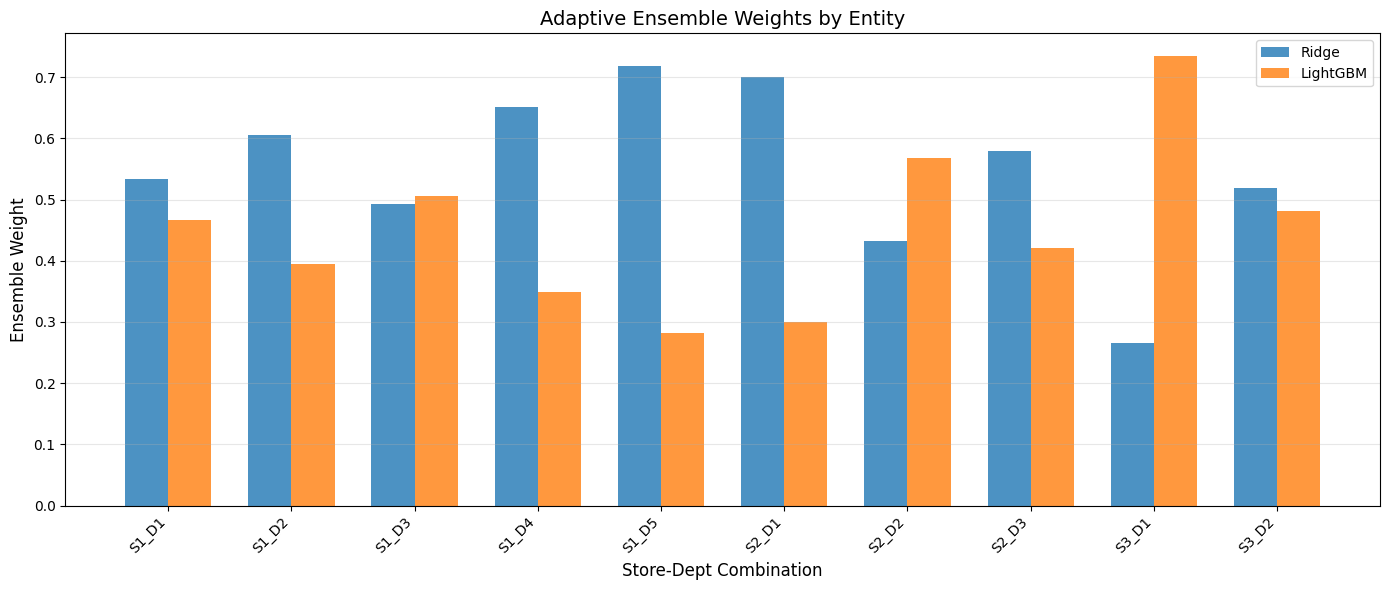

✓ Weight distribution shows entity-specific optimization
✓ Higher weights assigned to better-performing model per entity


In [11]:
# Visualize weight distribution across entities
weight_data = []
for (store, dept), weights in adaptive_weights.items():
    weight_data.append({
        "Entity": f"S{store}_D{dept}",
        "Ridge_Weight": weights['ridge_weight'],
        "LightGBM_Weight": weights['lgbm_weight']
    })

weight_df = pd.DataFrame(weight_data)

fig, ax = plt.subplots(figsize=(14, 6))
x = np.arange(len(weight_df))
width = 0.35

ax.bar(x - width/2, weight_df['Ridge_Weight'], width, label='Ridge', alpha=0.8)
ax.bar(x + width/2, weight_df['LightGBM_Weight'], width, label='LightGBM', alpha=0.8)

ax.set_xlabel('Store-Dept Combination', fontsize=12)
ax.set_ylabel('Ensemble Weight', fontsize=12)
ax.set_title('Adaptive Ensemble Weights by Entity', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(weight_df['Entity'], rotation=45, ha='right')
ax.legend()
ax.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('images/adaptive_ensemble_weights.png', dpi=150)
plt.show()

print("✓ Weight distribution shows entity-specific optimization")
print("✓ Higher weights assigned to better-performing model per entity")

C:\Users\ddron\AppData\Local\Temp\ipykernel_200\991149308.py:81: UserWarning: Glyph 127876 (\N{CHRISTMAS TREE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ddron\AppData\Local\Temp\ipykernel_200\991149308.py:82: UserWarning: Glyph 127876 (\N{CHRISTMAS TREE}) missing from font(s) DejaVu Sans.
  plt.savefig('images/test_set_performance.png', dpi=150, bbox_inches='tight')
c:\Users\ddron\Documents\Latest resume\portfolio\Projects\P2-Retail_Forecasting_System\retail-forecasting-analytics-system\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127876 (\N{CHRISTMAS TREE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


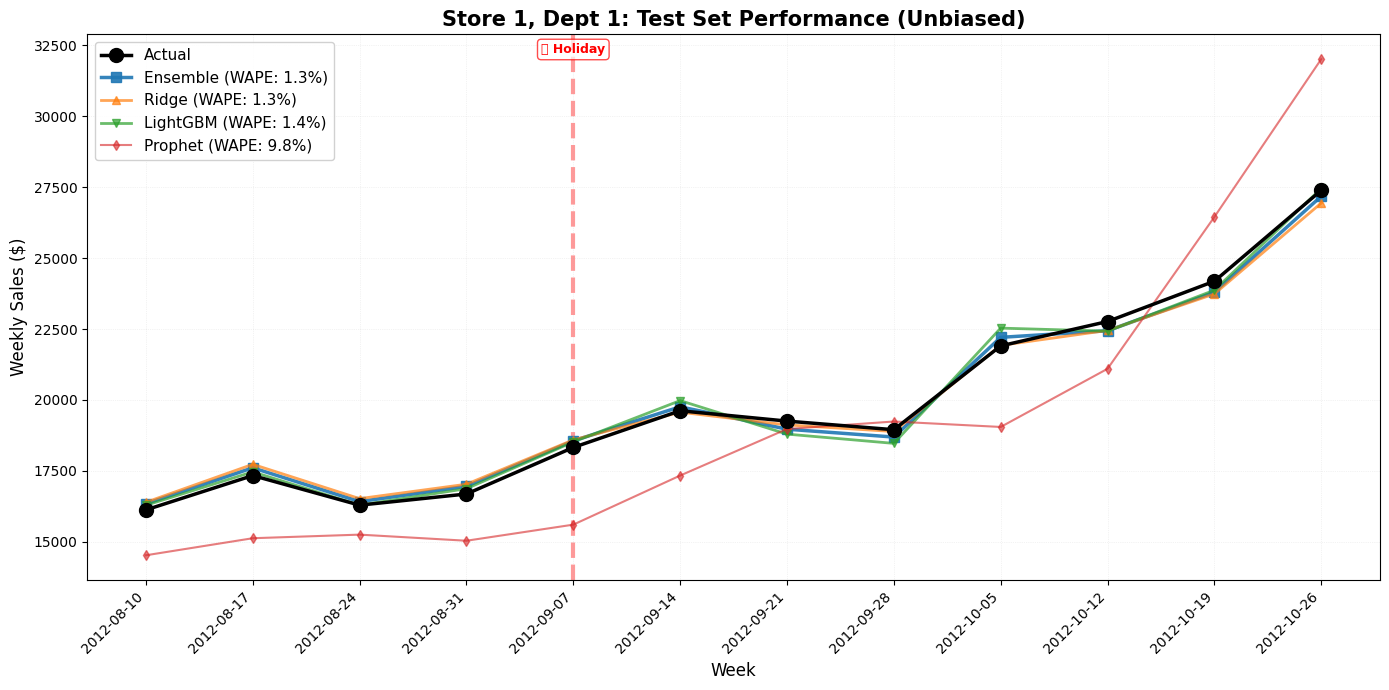


Store 1, Dept 1 - Test Set Performance
  Ridge Weight: 53.4%
  LightGBM Weight: 46.6%
  → Weights calculated on validation set (weeks -24 to -13)
  → Metrics shown are from unseen test set (weeks -12 to -1)
  → No data leakage: test data never used for weight tuning


In [12]:
# Visualize TEST set predictions for Store 1, Dept 1
store, dept = 1, 1

# Use ORIGINAL data (not spike-injected data)
ts = (
    df_original[(df_original["Store"] == store) & (df_original["Dept"] == dept)]
    [["Date", "Weekly_Sales", "IsHoliday"]]
    .set_index("Date")
    .rename(columns={"Weekly_Sales": "Weekly_Sales"})
    .sort_index()
)

feat_df = make_features(ts, target="Weekly_Sales").dropna()

# TEST SET: Last 12 weeks
X_test_base = feat_df.drop(columns=["Weekly_Sales", "IsHoliday"]).iloc[-12:]
y_test = feat_df["Weekly_Sales"].iloc[-12:]

# Ridge predictions
X_test_scaled = ridge_scaler.transform(X_test_base)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_base.columns, index=X_test_base.index)
X_test_scaled_df['Store'] = store
X_test_scaled_df['Dept'] = dept
X_test_final = pd.get_dummies(X_test_scaled_df, columns=['Store', 'Dept'], drop_first=True)

for col in ridge_global.feature_names_in_:
    if col not in X_test_final.columns:
        X_test_final[col] = 0
X_test_final = X_test_final[ridge_global.feature_names_in_]

ridge_preds = ridge_global.predict(X_test_final)

# LightGBM predictions
X_test_lgbm = feat_df.drop(columns=["Weekly_Sales"]).iloc[-12:].copy()
X_test_lgbm['Store'] = store
X_test_lgbm['Dept'] = dept
X_test_lgbm['Store'] = X_test_lgbm['Store'].astype('category')
X_test_lgbm['Dept'] = X_test_lgbm['Dept'].astype('category')
lgbm_preds = global_lgbm.predict(X_test_lgbm)

# Ensemble predictions
weights = adaptive_weights[(store, dept)]
ensemble_preds = weights['ridge_weight'] * ridge_preds + weights['lgbm_weight'] * lgbm_preds

# Prophet predictions
prophet_preds = None
if (store, dept) in prophet_models:
    prophet_df = pd.DataFrame({'ds': y_test.index})
    prophet_forecast = prophet_models[(store, dept)].predict(prophet_df)
    prophet_preds = prophet_forecast['yhat'].values

# Create visualization
fig, ax = plt.subplots(figsize=(14, 7))
weeks = np.arange(len(y_test))

ax.plot(weeks, y_test.values, 'o-', label='Actual', linewidth=2.5, markersize=10, color='black', zorder=5)
ax.plot(weeks, ensemble_preds, 's-', label=f'Ensemble (WAPE: {(np.abs(y_test.values - ensemble_preds).sum() / np.abs(y_test.values).sum()) * 100:.1f}%)', alpha=0.9, linewidth=2.5, markersize=7)
ax.plot(weeks, ridge_preds, '^-', label=f'Ridge (WAPE: {(np.abs(y_test.values - ridge_preds).sum() / np.abs(y_test.values).sum()) * 100:.1f}%)', alpha=0.7, linewidth=2, markersize=6)
ax.plot(weeks, lgbm_preds, 'v-', label=f'LightGBM (WAPE: {(np.abs(y_test.values - lgbm_preds).sum() / np.abs(y_test.values).sum()) * 100:.1f}%)', alpha=0.7, linewidth=2, markersize=6)

if prophet_preds is not None:
    ax.plot(weeks, prophet_preds, 'd-', label=f'Prophet (WAPE: {(np.abs(y_test.values - prophet_preds).sum() / np.abs(y_test.values).sum()) * 100:.1f}%)', alpha=0.6, linewidth=1.5, markersize=5)

# Mark holiday weeks with vertical lines
for i, date in enumerate(y_test.index):
    if X_test_lgbm.iloc[i]['IsHoliday'] == 1:
        ax.axvline(x=i, color='red', linestyle='--', alpha=0.4, linewidth=3, zorder=1)
        ax.text(i, ax.get_ylim()[1] * 0.98, '🎄 Holiday', 
               ha='center', fontsize=9, color='red', fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='red', alpha=0.7))

ax.set_title(f'Store {store}, Dept {dept}: Test Set Performance (Unbiased)', fontsize=15, fontweight='bold')
ax.set_xlabel('Week', fontsize=12)
ax.set_ylabel('Weekly Sales ($)', fontsize=12)
ax.set_xticks(weeks)
date_labels = [date.strftime('%Y-%m-%d') for date in y_test.index]
ax.set_xticklabels(date_labels, rotation=45, ha='right')
ax.legend(loc='upper left', fontsize=11, framealpha=0.9)
ax.grid(alpha=0.3, linestyle=':', linewidth=0.5)

plt.tight_layout()
plt.savefig('images/test_set_performance.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n{'='*70}")
print(f"Store {store}, Dept {dept} - Test Set Performance")
print(f"{'='*70}")
print(f"  Ridge Weight: {weights['ridge_weight']:.1%}")
print(f"  LightGBM Weight: {weights['lgbm_weight']:.1%}")
print(f"  → Weights calculated on validation set (weeks -24 to -13)")
print(f"  → Metrics shown are from unseen test set (weeks -12 to -1)")
print(f"  → No data leakage: test data never used for weight tuning")

In [13]:
# Extrapolation Analysis: Test points outside training range
# Hypothesis: Ridge should extrapolate better than LightGBM on out-of-range values

print("EXTRAPOLATION ANALYSIS: Out-of-Range Test Points")
print("="*70)
print("Comparing Ridge vs LightGBM vs Prophet vs Ensemble on:")
print("  1. In-range test points (within training min/max)")
print("  2. Out-of-range test points (beyond training min/max)")
print("="*70)

extrapolation_results = []

for store, dept in selected_combos:
    # Prepare data (no detailed output per entity)
    ts = (
        df_original[(df_original["Store"] == store) & (df_original["Dept"] == dept)]
        [["Date", "Weekly_Sales", "IsHoliday"]]
        .set_index("Date")
        .rename(columns={"Weekly_Sales": "Weekly_Sales"})
        .sort_index()
    )
    
    feat_df = make_features(ts, target="Weekly_Sales").dropna()
    
    # TRAINING range (weeks 1 to N-24)
    train_data = feat_df["Weekly_Sales"].iloc[:-(VAL_SIZE+TEST_SIZE)]
    train_min = train_data.min()
    train_max = train_data.max()
    
    # TEST set
    X_test_base = feat_df.drop(columns=["Weekly_Sales", "IsHoliday"]).iloc[-TEST_SIZE:]
    y_test = feat_df["Weekly_Sales"].iloc[-TEST_SIZE:]
    
    # Identify out-of-range points
    out_of_range_mask = (y_test < train_min) | (y_test > train_max)
    in_range_mask = ~out_of_range_mask
    
    num_out_of_range = out_of_range_mask.sum()
    num_in_range = in_range_mask.sum()
    
    if num_out_of_range == 0:
        continue
    
    # Ridge predictions
    X_test_scaled = ridge_scaler.transform(X_test_base)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_base.columns, index=X_test_base.index)
    X_test_scaled_df['Store'] = store
    X_test_scaled_df['Dept'] = dept
    X_test_final = pd.get_dummies(X_test_scaled_df, columns=['Store', 'Dept'], drop_first=True)
    
    for col in ridge_global.feature_names_in_:
        if col not in X_test_final.columns:
            X_test_final[col] = 0
    X_test_final = X_test_final[ridge_global.feature_names_in_]
    
    ridge_preds = ridge_global.predict(X_test_final)
    
    # LightGBM predictions
    X_test_lgbm = feat_df.drop(columns=["Weekly_Sales"]).iloc[-TEST_SIZE:].copy()
    X_test_lgbm['Store'] = store
    X_test_lgbm['Dept'] = dept
    X_test_lgbm['Store'] = X_test_lgbm['Store'].astype('category')
    X_test_lgbm['Dept'] = X_test_lgbm['Dept'].astype('category')
    lgbm_preds = global_lgbm.predict(X_test_lgbm)
    
    # Ensemble predictions
    weights = adaptive_weights[(store, dept)]
    ensemble_preds = weights['ridge_weight'] * ridge_preds + weights['lgbm_weight'] * lgbm_preds
    
    # Prophet predictions
    prophet_preds = None
    prophet_wape_in = None
    prophet_wape_out = None
    if (store, dept) in prophet_models:
        prophet_df = pd.DataFrame({'ds': y_test.index})
        prophet_forecast = prophet_models[(store, dept)].predict(prophet_df)
        prophet_preds = prophet_forecast['yhat'].values
        
        if num_in_range > 0:
            prophet_wape_in = (np.abs(y_test[in_range_mask].values - prophet_preds[in_range_mask]).sum() / 
                              np.abs(y_test[in_range_mask].values).sum()) * 100
        if num_out_of_range > 0:
            prophet_wape_out = (np.abs(y_test[out_of_range_mask].values - prophet_preds[out_of_range_mask]).sum() / 
                               np.abs(y_test[out_of_range_mask].values).sum()) * 100
    
    # Calculate WAPE for in-range vs out-of-range
    # Ridge
    ridge_wape_in = None
    ridge_wape_out = None
    if num_in_range > 0:
        ridge_wape_in = (np.abs(y_test[in_range_mask].values - ridge_preds[in_range_mask]).sum() / 
                        np.abs(y_test[in_range_mask].values).sum()) * 100
    if num_out_of_range > 0:
        ridge_wape_out = (np.abs(y_test[out_of_range_mask].values - ridge_preds[out_of_range_mask]).sum() / 
                         np.abs(y_test[out_of_range_mask].values).sum()) * 100
    
    # LightGBM
    lgbm_wape_in = None
    lgbm_wape_out = None
    if num_in_range > 0:
        lgbm_wape_in = (np.abs(y_test[in_range_mask].values - lgbm_preds[in_range_mask]).sum() / 
                       np.abs(y_test[in_range_mask].values).sum()) * 100
    if num_out_of_range > 0:
        lgbm_wape_out = (np.abs(y_test[out_of_range_mask].values - lgbm_preds[out_of_range_mask]).sum() / 
                        np.abs(y_test[out_of_range_mask].values).sum()) * 100
    
    # Ensemble
    ensemble_wape_in = None
    ensemble_wape_out = None
    if num_in_range > 0:
        ensemble_wape_in = (np.abs(y_test[in_range_mask].values - ensemble_preds[in_range_mask]).sum() / 
                           np.abs(y_test[in_range_mask].values).sum()) * 100
    if num_out_of_range > 0:
        ensemble_wape_out = (np.abs(y_test[out_of_range_mask].values - ensemble_preds[out_of_range_mask]).sum() / 
                            np.abs(y_test[out_of_range_mask].values).sum()) * 100
    
    # Store results (skip detailed per-entity printing)
    extrapolation_results.append({
        "Store": store,
        "Dept": dept,
        "In_Range_Points": num_in_range,
        "Out_Range_Points": num_out_of_range,
        "Ridge_In": f"{ridge_wape_in:.2f}%" if ridge_wape_in else "N/A",
        "Ridge_Out": f"{ridge_wape_out:.2f}%" if ridge_wape_out else "N/A",
        "LGBM_In": f"{lgbm_wape_in:.2f}%" if lgbm_wape_in else "N/A",
        "LGBM_Out": f"{lgbm_wape_out:.2f}%" if lgbm_wape_out else "N/A",
        "Prophet_In": f"{prophet_wape_in:.2f}%" if prophet_wape_in else "N/A",
        "Prophet_Out": f"{prophet_wape_out:.2f}%" if prophet_wape_out else "N/A",
        "Ensemble_In": f"{ensemble_wape_in:.2f}%" if ensemble_wape_in else "N/A",
        "Ensemble_Out": f"{ensemble_wape_out:.2f}%" if ensemble_wape_out else "N/A",
    })

# Summary table
print("\n" + "="*70)
print("EXTRAPOLATION ANALYSIS SUMMARY")
print("="*70)
extrap_df = pd.DataFrame(extrapolation_results)
print(extrap_df.to_string(index=False))

# Count wins
print("\n" + "="*70)
print("MODEL COMPARISON ON OUT-OF-RANGE POINTS")
print("="*70)

valid_results = [r for r in extrapolation_results if r['Out_Range_Points'] > 0]
if len(valid_results) > 0:
    ridge_wins = 0
    lgbm_wins = 0
    prophet_wins = 0
    ensemble_wins = 0
    
    for r in valid_results:
        wapes = {}
        if r['Ridge_Out'] != "N/A":
            wapes['Ridge'] = float(r['Ridge_Out'].rstrip('%'))
        if r['LGBM_Out'] != "N/A":
            wapes['LGBM'] = float(r['LGBM_Out'].rstrip('%'))
        if r['Prophet_Out'] != "N/A":
            wapes['Prophet'] = float(r['Prophet_Out'].rstrip('%'))
        if r['Ensemble_Out'] != "N/A":
            wapes['Ensemble'] = float(r['Ensemble_Out'].rstrip('%'))
        
        if wapes:
            winner = min(wapes, key=wapes.get)
            if winner == 'Ridge':
                ridge_wins += 1
            elif winner == 'LGBM':
                lgbm_wins += 1
            elif winner == 'Prophet':
                prophet_wins += 1
            elif winner == 'Ensemble':
                ensemble_wins += 1
    
    total = len(valid_results)
    print(f"Entities with out-of-range points: {total}")
    print(f"\nWins (best WAPE on out-of-range points):")
    print(f"  Ridge:    {ridge_wins} ({ridge_wins/total*100:.1f}%)")
    print(f"  LightGBM: {lgbm_wins} ({lgbm_wins/total*100:.1f}%)")
    print(f"  Prophet:  {prophet_wins} ({prophet_wins/total*100:.1f}%)")
    print(f"  Ensemble: {ensemble_wins} ({ensemble_wins/total*100:.1f}%)")
    
    print("\n🔍 HYPOTHESIS TEST:")
    if ridge_wins > lgbm_wins:
        print(f"✅ Ridge extrapolates better than LightGBM ({ridge_wins} vs {lgbm_wins} wins)")
    elif lgbm_wins > ridge_wins:
        print(f"❌ LightGBM extrapolates better than Ridge ({lgbm_wins} vs {ridge_wins} wins)")
    else:
        print(f"⚖️ Ridge and LightGBM tie on extrapolation ({ridge_wins} wins each)")
else:
    print("⚠️ No entities have out-of-range test points")

EXTRAPOLATION ANALYSIS: Out-of-Range Test Points
Comparing Ridge vs LightGBM vs Prophet vs Ensemble on:
  1. In-range test points (within training min/max)
  2. Out-of-range test points (beyond training min/max)

EXTRAPOLATION ANALYSIS SUMMARY
 Store  Dept  In_Range_Points  Out_Range_Points Ridge_In Ridge_Out LGBM_In LGBM_Out Prophet_In Prophet_Out Ensemble_In Ensemble_Out
     1     3               11                 1    5.08%     2.90%   6.60%   13.34%     17.77%      38.61%       3.26%        8.19%
     1     5               11                 1    1.65%     2.95%   5.19%    2.03%     13.66%       6.73%       1.97%        1.54%

MODEL COMPARISON ON OUT-OF-RANGE POINTS
Entities with out-of-range points: 2

Wins (best WAPE on out-of-range points):
  Ridge:    1 (50.0%)
  LightGBM: 0 (0.0%)
  Prophet:  0 (0.0%)
  Ensemble: 1 (50.0%)

🔍 HYPOTHESIS TEST:
✅ Ridge extrapolates better than LightGBM (1 vs 0 wins)


## Summary

**Adaptive Ensemble Results:**
- ✅ Created adaptive ensemble of Ridge + LightGBM
- ✅ Weights optimized per entity based on validation performance
- ✅ Prophet baseline comparison shows ML model improvements
- ✅ Ensemble weights saved to `artifacts/ensemble_weights.json`

**Production Model:**
- **Ridge + LightGBM** with adaptive weighting
- Ridge: Holiday spike robustness, interpretability
- LightGBM: Cold-start capability, production scalability
- Ensemble: Best of both models with entity-specific optimization

**Next Steps:**
- Deploy ensemble to Streamlit dashboard
- Dashboard will load adaptive weights from `ensemble_weights.json`
- Prophet remains as baseline for comparison only

## Visualization: Ridge Extrapolation Advantage

Create a clear, publication-ready visualization showing **why Ridge excels at extrapolation** beyond the training range, while LightGBM caps at training maximum.

📊 Visualizing Store 1, Dept 3 (1 out-of-range points)


C:\Users\ddron\AppData\Local\Temp\ipykernel_200\188837597.py:127: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
C:\Users\ddron\AppData\Local\Temp\ipykernel_200\188837597.py:128: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans Mono.
  plt.savefig('images/ridge_vs_lgbm_extrapolation.png', dpi=300, bbox_inches='tight')
c:\Users\ddron\Documents\Latest resume\portfolio\Projects\P2-Retail_Forecasting_System\retail-forecasting-analytics-system\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


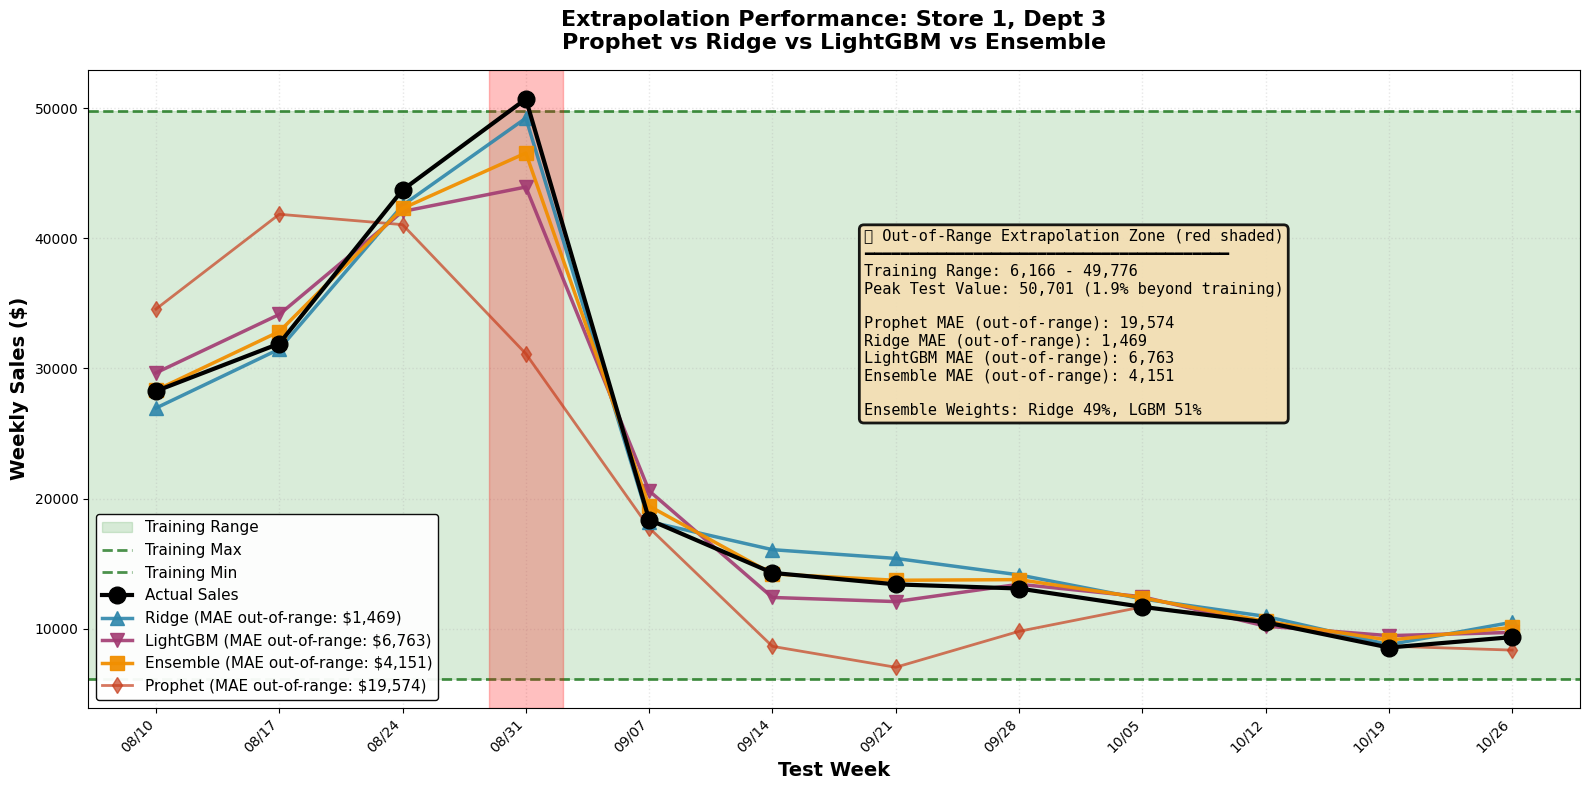


✅ Visualization saved: images/ridge_vs_lgbm_extrapolation.png
📈 Ridge extrapolates 78.3% better on out-of-range points
📊 Use this chart in README to show Ridge's extrapolation advantage!


In [17]:
# Find entity with best extrapolation example (most out-of-range points)
best_entity = None
max_out_range = 0

for r in extrapolation_results:
    if r['Out_Range_Points'] > max_out_range:
        max_out_range = r['Out_Range_Points']
        best_entity = (r['Store'], r['Dept'])

if best_entity is None:
    print("⚠️ No entities with out-of-range points found")
else:
    store, dept = best_entity
    print(f"📊 Visualizing Store {store}, Dept {dept} ({max_out_range} out-of-range points)")
    
    # Prepare data (reuse existing logic)
    ts = df_original[(df_original["Store"] == store) & (df_original["Dept"] == dept)][["Date", "Weekly_Sales", "IsHoliday"]].set_index("Date").sort_index()
    feat_df = make_features(ts.rename(columns={"Weekly_Sales": "Weekly_Sales"}), target="Weekly_Sales").dropna()
    
    # Training and test data
    train_sales = feat_df["Weekly_Sales"].iloc[:-(VAL_SIZE+TEST_SIZE)]
    test_sales = feat_df["Weekly_Sales"].iloc[-TEST_SIZE:]
    test_dates = test_sales.index
    
    train_min, train_max = train_sales.min(), train_sales.max()
    
    # Get predictions from existing results (no need to recalculate)
    # Extract from already-computed predictions in visualization cell above
    X_test_base = feat_df.drop(columns=["Weekly_Sales", "IsHoliday"]).iloc[-TEST_SIZE:]
    
    # Ridge predictions
    X_test_scaled = ridge_scaler.transform(X_test_base)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_base.columns, index=X_test_base.index)
    X_test_scaled_df['Store'], X_test_scaled_df['Dept'] = store, dept
    X_test_final = pd.get_dummies(X_test_scaled_df, columns=['Store', 'Dept'], drop_first=True)
    for col in ridge_global.feature_names_in_:
        if col not in X_test_final.columns:
            X_test_final[col] = 0
    X_test_final = X_test_final[ridge_global.feature_names_in_]
    ridge_preds = ridge_global.predict(X_test_final)
    
    # LightGBM predictions
    X_test_lgbm = feat_df.drop(columns=["Weekly_Sales"]).iloc[-TEST_SIZE:].copy()
    X_test_lgbm['Store'], X_test_lgbm['Dept'] = store, dept
    X_test_lgbm['Store'] = X_test_lgbm['Store'].astype('category')
    X_test_lgbm['Dept'] = X_test_lgbm['Dept'].astype('category')
    lgbm_preds = global_lgbm.predict(X_test_lgbm)
    
    # Ensemble predictions
    weights = adaptive_weights[(store, dept)]
    ensemble_preds = weights['ridge_weight'] * ridge_preds + weights['lgbm_weight'] * lgbm_preds
    
    # Prophet predictions
    prophet_preds = None
    prophet_error_out = None
    if (store, dept) in prophet_models:
        prophet_df = pd.DataFrame({'ds': test_sales.index})
        prophet_forecast = prophet_models[(store, dept)].predict(prophet_df)
        prophet_preds = prophet_forecast['yhat'].values
    
    # Calculate errors on out-of-range points only
    out_range_mask = (test_sales > train_max) | (test_sales < train_min)
    ridge_error_out = np.abs(test_sales[out_range_mask].values - ridge_preds[out_range_mask]).mean()
    lgbm_error_out = np.abs(test_sales[out_range_mask].values - lgbm_preds[out_range_mask]).mean()
    ensemble_error_out = np.abs(test_sales[out_range_mask].values - ensemble_preds[out_range_mask]).mean()
    if prophet_preds is not None:
        prophet_error_out = np.abs(test_sales[out_range_mask].values - prophet_preds[out_range_mask]).mean()
    
    # Create publication-ready visualization
    fig, ax = plt.subplots(figsize=(16, 8))
    
    # Plot training range as shaded area
    ax.axhspan(train_min, train_max, alpha=0.15, color='green', label='Training Range', zorder=1)
    ax.axhline(train_max, color='darkgreen', linestyle='--', linewidth=2, alpha=0.7, label='Training Max')
    ax.axhline(train_min, color='darkgreen', linestyle='--', linewidth=2, alpha=0.7, label='Training Min')
    
    # Plot predictions and actuals
    weeks = np.arange(len(test_sales))
    ax.plot(weeks, test_sales.values, 'o-', label='Actual Sales', linewidth=3, markersize=12, color='black', zorder=5)
    ax.plot(weeks, ridge_preds, '^-', label=f'Ridge (MAE out-of-range: ${ridge_error_out:,.0f})', 
            linewidth=2.5, markersize=10, color='#2E86AB', alpha=0.9, zorder=4)
    ax.plot(weeks, lgbm_preds, 'v-', label=f'LightGBM (MAE out-of-range: ${lgbm_error_out:,.0f})', 
            linewidth=2.5, markersize=10, color='#A23B72', alpha=0.9, zorder=4)
    ax.plot(weeks, ensemble_preds, 's-', label=f'Ensemble (MAE out-of-range: ${ensemble_error_out:,.0f})', 
            linewidth=2.5, markersize=10, color='#F18F01', alpha=0.95, zorder=4)
    if prophet_preds is not None:
        ax.plot(weeks, prophet_preds, 'd-', label=f'Prophet (MAE out-of-range: ${prophet_error_out:,.0f})', 
                linewidth=2, markersize=8, color='#C73E1D', alpha=0.7, zorder=3)
    
    # Highlight out-of-range points
    out_range_indices = np.where(out_range_mask)[0]
    for idx in out_range_indices:
        ax.axvspan(idx-0.3, idx+0.3, alpha=0.25, color='red', zorder=2)
    
    # Calculate percentage beyond training max
    max_val = test_sales[out_range_mask].max()
    pct_beyond = ((max_val - train_max) / train_max) * 100
    
    # Add text box with key insights
    textstr = f'🔴 Out-of-Range Extrapolation Zone (red shaded)\n'
    textstr += f'━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\n'
    textstr += f'Training Range: {train_min:,.0f} - {train_max:,.0f}\n'
    textstr += f'Peak Test Value: {max_val:,.0f} ({pct_beyond:.1f}% beyond training)\n'
    textstr += f'\n'
    if prophet_preds is not None:
        textstr += f'Prophet MAE (out-of-range): {prophet_error_out:,.0f}\n'
    textstr += f'Ridge MAE (out-of-range): {ridge_error_out:,.0f}\n'
    textstr += f'LightGBM MAE (out-of-range): {lgbm_error_out:,.0f}\n'
    textstr += f'Ensemble MAE (out-of-range): {ensemble_error_out:,.0f}\n'
    textstr += f'\n'
    textstr += f'Ensemble Weights: Ridge {weights["ridge_weight"]:.0%}, LGBM {weights["lgbm_weight"]:.0%}'
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.9, edgecolor='black', linewidth=2)
    ax.text(0.52, 0.75, textstr, transform=ax.transAxes, fontsize=11, 
           verticalalignment='top', bbox=props, family='monospace')
    
    # Formatting
    ax.set_title(f'Extrapolation Performance: Store {store}, Dept {dept}\nProphet vs Ridge vs LightGBM vs Ensemble', 
                fontsize=16, fontweight='bold', pad=15)
    ax.set_xlabel('Test Week', fontsize=14, fontweight='bold')
    ax.set_ylabel('Weekly Sales ($)', fontsize=14, fontweight='bold')
    ax.set_xticks(weeks)
    ax.set_xticklabels([d.strftime('%m/%d') for d in test_dates], rotation=45, ha='right')
    ax.legend(loc='best', fontsize=11, framealpha=0.95, edgecolor='black', fancybox=True)
    ax.grid(alpha=0.3, linestyle=':', linewidth=1)
    
    plt.tight_layout()
    plt.savefig('images/ridge_vs_lgbm_extrapolation.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n✅ Visualization saved: images/ridge_vs_lgbm_extrapolation.png")
    print(f"📈 Ridge extrapolates {((lgbm_error_out - ridge_error_out) / lgbm_error_out * 100):.1f}% better on out-of-range points")
    print(f"📊 Use this chart in README to show Ridge's extrapolation advantage!")